In [1]:
import squigglepy as sq
import numpy as np

from datetime import datetime
from pprint import pprint

from libs import run_model, calculate_doubling_time, plot_exponential_growth


O3_LAUNCH_DATE = datetime(2025, 4, 16)
CLAUDE_3P7_LAUNCH_DATE = datetime(2025, 2, 24)

print('Loaded libraries')

Loaded libraries


In [2]:
print('## START task length (displayed in min) ##')

# -- DEFINE CURRENT BEST
current_best = 1.75 # o3 task length at 50% reliability?

# -- DEFINE ADJUSTMENTS
elicitation_boost = sq.mixture([[0.3, 1], # Can you get a boost to scores by iterating on scaffolding and other elicitation techniques? 30% chance no, 40% chance you can get a 1.2x speed up, 30% chance of 1.5x.
                                [0.4, 1.2],
                                [0.3, 1.5]])

inference_compute_adj = sq.lognorm(lognorm_mean=2, lognorm_sd=1, lclip=1) # Can you get a boost to scores by increasing inference compute to human level? Approx doubling
                               
reliability_needed = sq.mixture([[0.2, 0.5], # What amount of reliability will we need? Probability distribution over hypotheses
                                 [0.4, 0.8],
                                 [0.2, 0.9],
                                 [0.1, 0.95],
                                 [0.1, 0.99]])

def reliability_count_to_penalty(reliability):
    r = np.asarray(reliability, dtype=float)
    reliability = np.array([0.50, 0.80, 0.90, 0.95, 0.99])
    penalty = np.array([1.0, 0.25, 0.25**2, 0.25**3, 0.25**4])
    matches = r[..., None] == reliability
    hit_any = matches.any(axis=-1)
    idx = matches.argmax(axis=-1)
    out = np.full_like(r, np.nan, dtype=float)
    out[hit_any] = penalty[idx[hit_any]]
    return out

task_type_penalty = sq.mixture([[0.1, 1],                         # 10% chance that METR's software tasks are sufficient for AGI
                                [0.3, 1 / sq.lognorm(5, 20)],     # 30% chance that true AGI tasks are 5-20x harder than METR's software tasks
                                [0.6, 1 / sq.lognorm(10, 1000)]]) # 60% chance that true AGI tasks are 10-1000x harder than METR's software tasks

# -- CREATE DISTRIBUTION
# Start with current best, add elicitation boost
start_task_length = current_best * elicitation_boost

# add inference compute adjustment
start_task_length = start_task_length * inference_compute_adj

# add reliability penalty
start_task_length = start_task_length * sq.dist_fn(reliability_needed, reliability_count_to_penalty)

# Add task type penalty
start_task_length *= task_type_penalty

# Add a minimum value of 1sec
start_task_length = sq.dist_max(1/60/60, start_task_length)

# Show samples in minutes (naturally in hours)
sq.get_percentiles((start_task_length * 60) @ 100_000, digits=2)

## START task length (displayed in min) ##


{1: 0.02,
 5: 0.02,
 10: 0.03,
 20: 0.1,
 30: 0.24,
 40: 0.51,
 50: 1.02,
 60: 2.04,
 70: 4.09,
 80: 8.53,
 90: 25.08,
 95: 54.96,
 99: 233.87}

In [3]:
print('## AGI task length (displayed in hrs) ##')
agi_task_length = sq.lognorm(80, 2000, credibility=80, lclip=40)
sq.get_percentiles(agi_task_length @ 100_000, digits=0)

## AGI task length (displayed in hrs) ##


{1: 40,
 5: 51,
 10: 80,
 20: 140,
 30: 208,
 40: 293,
 50: 402,
 60: 554,
 70: 780,
 80: 1162,
 90: 2020,
 95: 3197,
 99: 7527}

In [4]:
print('## DOUBLING TIME (displayed in days) ##')
doubling_time = sq.mixture([[0.3, 212],
                            [0.1, 118],
                            [0.6, sq.lognorm(lognorm_mean=185.25, lognorm_sd=40)]])
sq.get_percentiles(doubling_time @ 100_000, digits=0)

## DOUBLING TIME (displayed in days) ##


{1: 115,
 5: 118,
 10: 118,
 20: 147,
 30: 165,
 40: 181,
 50: 199,
 60: 212,
 70: 212,
 80: 212,
 90: 222,
 95: 243,
 99: 285}

In [5]:
print('## ACCELERATION (displayed in days)')
acceleration = sq.mixture([[0.1, 1 + sq.lognorm(0.005, 0.1, credibility=80)],
                           [0.8, 1],
                           [0.1, 1 - sq.lognorm(0.005, 0.1, credibility=80)]])
sq.get_percentiles(acceleration @ 100_000, digits=3)

## ACCELERATION (displayed in days)


{1: 0.902,
 5: 0.978,
 10: 1.0,
 20: 1.0,
 30: 1.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.001,
 95: 1.023,
 99: 1.098}

In [6]:
print('## SHIFT (displayed in days) ##')
shift = sq.norm(30, 30*5, credibility=80, lclip=0)
sq.get_percentiles(shift @ 100_000, digits=0)

## SHIFT (displayed in days) ##


{1: 0,
 5: 13,
 10: 30,
 20: 50,
 30: 65,
 40: 78,
 50: 90,
 60: 102,
 70: 115,
 80: 129,
 90: 150,
 95: 167,
 99: 199}

In [7]:
def adapted_metr_model():
    start_task_length_ = start_task_length * (2 ** (shift / doubling_time))
    days = calculate_doubling_time(start_task_length_, agi_task_length, doubling_time, acceleration)
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add measurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

samples = run_model(adapted_metr_model, index_date=O3_LAUNCH_DATE, cores=4)

Generating samples with 4 cores...


100%|███████████████████████████████████████████████████████████████████████████| 100000/100000 [00:20<00:00, 4857.75it/s]


Shuffling data...
Waiting for other cores...


100%|█████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 2261.39it/s]


...Collected!
{1: 855,
 5: 1255,
 10: 1516,
 20: 1895,
 30: 2203,
 40: 2491,
 50: 2769,
 60: 3083,
 70: 3457,
 80: 3893,
 90: 4563,
 95: 5144,
 99: 6418}

-

{1: '2027 Aug 18',
 5: '2028 Sep 23',
 10: '2029 Jun 11',
 20: '2030 Jun 24',
 30: '2031 Apr 29',
 40: '2032 Feb 10',
 50: '2032 Nov 14',
 60: '2033 Sep 24',
 70: '2034 Oct 04',
 80: '2035 Dec 14',
 90: '2037 Oct 13',
 95: '2039 May 17',
 99: '2042 Nov 12'}


In [8]:
print('## DISTRIBUTION OF AGI ARRIVAL DATE ##')
# Convert datetime samples to years
agi_years = [s / 365 + 2025 for s in samples]
pctiles = sq.get_percentiles(agi_years, percentiles=[1, 2, 3, 4, 5, 10, 15, 20, 25, 35, 50, 60, 75, 80, 90, 95])
pprint([
    ((str(o[0]) + '%: ' + str(round(o[1], 1))) if o[1] < 2100 else '>2100') 
    for o in pctiles.items()
])
print('')
print('')
print('## DISTRIBUTION OF RELATIVE AGI ARRIVAL DATE ##')
pprint([
    ((str(o[0]) + '%: ' + str(round(o[1] - 2025, 1))) if o[1] < 2100 else '>75') + ' years from now' 
    for o in pctiles.items()
])
print('(Mean: {} years from now)'.format(int(round(np.mean([t - 2025 for t in agi_years])))))
print('')
print('')


print('## AGI ARRIVAL DATE BY BIN ##')

def bin_agi_yrs(low=None, hi=None):
    low = 2025 if low is None else low
    if hi is None:
        r = np.mean([y >= low for y in agi_years])
    else:
        r = np.mean([(y >= low) and (y <= hi) for y in agi_years])
    return round(r * 100, 1)


year_pairs = [[2025, 2026],
              [2026, 2027],
              [2027, 2028],
              [2028, 2029],
              [2029, 2030],
              [2030, 2032],
              [2032, 2035],
              [2035, 2040],
              [2040, 2050],
              [2050, 2060],
              [2060, 2070],
              [2070, 2080],
              [2080, 2090],
              [2090, 2100]]
for y in year_pairs:
    if y[0] == y[1] - 1:
        print('{}: {}%'.format(y[0], bin_agi_yrs(y[0], y[1])))
    else:
        print('{}-{}: {}%'.format(y[0], y[1]-1, bin_agi_yrs(y[0], y[1])))
print('>{}: {}%'.format(2100, bin_agi_yrs(low=2100)))
print('')
print('')

print('## AGI ARRIVAL DATE BY YEAR ##')
for y in list(range(2025, 2035)) + list(range(2035, 2100, 5)):
    print('By EOY {}: {}%'.format(y, bin_agi_yrs(hi=y+1)))
print('')

## DISTRIBUTION OF AGI ARRIVAL DATE ##
['1%: 2027.3',
 '2%: 2027.7',
 '3%: 2028.0',
 '4%: 2028.2',
 '5%: 2028.4',
 '10%: 2029.2',
 '15%: 2029.7',
 '20%: 2030.2',
 '25%: 2030.6',
 '35%: 2031.4',
 '50%: 2032.6',
 '60%: 2033.4',
 '75%: 2035.0',
 '80%: 2035.7',
 '90%: 2037.5',
 '95%: 2039.1']


## DISTRIBUTION OF RELATIVE AGI ARRIVAL DATE ##
['1%: 2.3 years from now',
 '2%: 2.7 years from now',
 '3%: 3.0 years from now',
 '4%: 3.2 years from now',
 '5%: 3.4 years from now',
 '10%: 4.2 years from now',
 '15%: 4.7 years from now',
 '20%: 5.2 years from now',
 '25%: 5.6 years from now',
 '35%: 6.4 years from now',
 '50%: 7.6 years from now',
 '60%: 8.4 years from now',
 '75%: 10.0 years from now',
 '80%: 10.7 years from now',
 '90%: 12.5 years from now',
 '95%: 14.1 years from now']
(Mean: 8 years from now)


## AGI ARRIVAL DATE BY BIN ##
2025: 0.0%
2026: 0.5%
2027: 2.4%
2028: 6.0%
2029: 9.2%
2030-2031: 24.3%
2032-2034: 32.4%
2035-2039: 22.0%
2040-2049: 3.3%
2050-2059: 0.0%
2060-2069: 0.0%
20

## Overall prediction

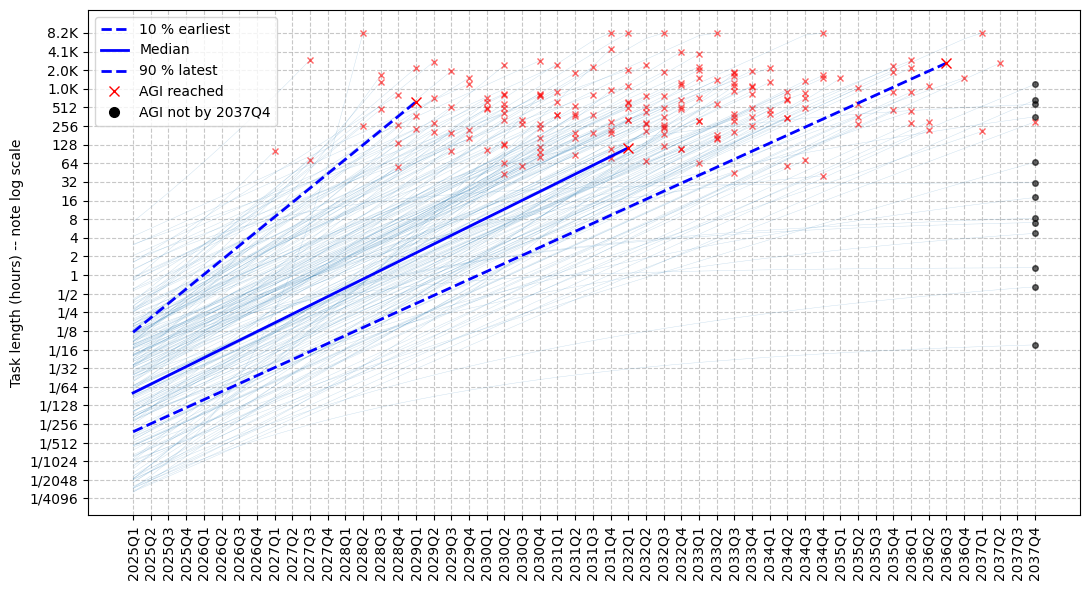

In [9]:
plot_exponential_growth(
    doubling_time_days=doubling_time,
    starting_hours=start_task_length,
    agi_task_length=agi_task_length,
    shift=shift,
    acceleration=acceleration,
    n_quarters=51,
    n_samples=100_000,
    n_traces=200,
    max_task_power=13,
    min_y_power=-15,
)